# Complete Restart with JOGs using Orthofinder results
JOGs are Josiah's Orthogroups from Orthofinder run using latest assemblies

# HOG file parsing for gene names

In [12]:
from DNASkittleUtils.Contigs import read_contigs
from DNASkittleUtils.DDVUtils import pp
from os.path import join, basename, splitext
import os

In [1]:
def convert_to_gene_id(name):
    if name.startswith('FRAX00'):
        name = name.replace('FRAX00_FRAEX38873_v2_', '')
        return name#[:name.rfind('.')]
    if name.startswith('FRAX'):  # not FRAEX for excelsior
        pieces = name.split('_')
        name = pieces[2] + '_' + pieces[3]
        return name#[:name.rfind('.')]
    else:
        return name
assert convert_to_gene_id("FRAX19_FRAX19_000226960.2_R0") == "000226960.2_R0", convert_to_gene_id("FRAX19_FRAX19_000226960.2_R0")
assert convert_to_gene_id("FRAX00_FRAEX38873_v2_000001220.2") == "000001220.2", convert_to_gene_id("FRAX00_FRAEX38873_v2_000001220.2")
tomato = 'Solyc03g095770.2.1 pacid=36135394 transcript=Solyc03g095770.2.1 locus=Solyc03g095770.2 ID=Solyc03g095770.2.1.ITAG2.4 annot-version=ITAG2.4 [Slycopersicum_390_ITAG2]'
assert convert_to_gene_id(tomato) == tomato


In [2]:
def parse_HOGs_from_fasta_directory():
    directory_HOGs = r"D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\Ash_Proteome\Results_Jun25\Orthologues_Jul06\Sequences"
    from glob import glob
    from os.path import join, splitext, basename
    file_list = glob(join(directory_HOGs, "*.fa"))
    HOGs = {}
    for i, filename in enumerate(file_list):
        if i % 1000 == 0:
            print(basename(filename))
        assert basename(filename).startswith('OG')
        headers = []
        with open(filename, 'r') as fasta:
            for line in fasta:
                if line.startswith('>'):
                    headers.append(convert_to_gene_id(line[1:-1]))
        #assert len(headers) == len(set(headers)), "There was a redundant gene mention %s" % headers 
        HOGs[basename(splitext(filename)[0])] = headers
    return HOGs
HOGs = parse_HOGs_from_fasta_directory()
len(HOGs)

OG0000000.fa
OG0001000.fa
OG0002000.fa
OG0003000.fa
OG0004000.fa
OG0005000.fa
OG0006000.fa
OG0007000.fa
OG0008000.fa
OG0009000.fa
OG0010000.fa
OG0011000.fa
OG0012000.fa
OG0013000.fa
OG0014000.fa
OG0015000.fa
OG0016000.fa
OG0017000.fa
OG0018000.fa
OG0019000.fa
OG0020000.fa
OG0021000.fa
OG0022000.fa
OG0023000.fa
OG0024000.fa
OG0025000.fa
OG0026000.fa
OG0027000.fa
OG0028000.fa
OG0029000.fa
OG0030000.fa
OG0031000.fa
OG0032000.fa
OG0033000.fa
OG0034000.fa
OG0035000.fa
OG0036000.fa
OG0037000.fa
OG0038000.fa
OG0039000.fa
OG0040000.fa
OG0041000.fa
OG0042000.fa
OG0043000.fa
OG0044000.fa
OG0045000.fa
OG0046000.fa
OG0047000.fa
OG0048000.fa
OG0049000.fa
OG0050000.fa
OG0051000.fa
OG0052000.fa
OG0053000.fa
OG0054000.fa
OG0055000.fa
OG0056000.fa
OG0057000.fa
OG0058000.fa
OG0059000.fa
OG0060000.fa
OG0061000.fa
OG0062000.fa
OG0063000.fa
OG0064000.fa


64650

In [3]:
HOGs['OG0047000']

['Oeuropea_OE6A039394P1']

# GFF parsing for overlapping annotations

TBD

# Greedy merge algorithm
 ( agglomerative clustering? )
* Starting clusters can be HOGs
* clusters = dict{ gene: pointer to cluster }
* Clusters are set(gene)
* First gene gets a new cluster
* If gene A overlaps with gene B anywhere, then go through each cluster to find gene A and add gene B
* If gene B is in any other clusters, find it and merge the entire cluster into gene A cluster
* Assert a gene can only ever be in one cluster at a time, except in the atomic operation of merging two


### Starting from HOGs but no side-effects, using networkx to retreive clusters

[Python Network Graphs](https://www.python.org/doc/essays/graphs/)

[Creating a networkx graph](https://networkx.github.io/documentation/networkx-1.10/tutorial/tutorial.html)  
[Graph Connected Components](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.components.connected.connected_components.html)

In [4]:
def map_genes_to_HOGs(HOGs):
    genes_to_HOGs = {}
    for hog, genes in HOGs.items():
        for gene in genes:
            if gene not in genes_to_HOGs:
                genes_to_HOGs[gene] = set()
            genes_to_HOGs[gene].add(hog)
    return genes_to_HOGs

def test_map_genes_to_HOGs():
    genes_to_HOGs_answer = {'gene1': {'HOG1'},
                     'gene2': {'HOG1', 'HOG2'},
                     'gene3': {'HOG2'}}
    HOGs = {'HOG1': set(('gene1', 'gene2')),
            'HOG2': set(('gene2', 'gene3'))}  # all HOGs start out parsed and non-exlusive
    genes_to_HOGs = map_genes_to_HOGs(HOGs)
    print(genes_to_HOGs, '\n',genes_to_HOGs_answer)
    assert genes_to_HOGs == genes_to_HOGs_answer
test_map_genes_to_HOGs()    

{'gene3': {'HOG2'}, 'gene2': {'HOG1', 'HOG2'}, 'gene1': {'HOG1'}} 
 {'gene3': {'HOG2'}, 'gene2': {'HOG1', 'HOG2'}, 'gene1': {'HOG1'}}


In [5]:
from itertools import combinations
import networkx

def create_cluster_network(genes_to_HOGs, HOGs, blacklist_genes=set(), blacklist_HOGs=set()):
    g = networkx.Graph()
    g.add_nodes_from(HOGs.keys())
    for gene, hogs in genes_to_HOGs.items():
        if len(hogs) > 1:
            if gene not in blacklist_genes:
                target_hogs = hogs.difference(blacklist_HOGs)
                # two HOGs have overlap and need to be merged
                g.add_edges_from(combinations(target_hogs, 2))  # add edge between all hogs
            
    return g

In [6]:
def make_super_HOGs(HOGs, networked_hogs):
    """collect subnetworks together into larger clusters"""
    super_HOGs = {}
    genes_seen = set()
    clusters = [c for c in sorted(networkx.connected_components(networked_hogs), key=len, reverse=True)]
    for cluster in clusters:
        name = '-'.join(cluster)
        super_HOGs[name] = set().union(gene for hog in cluster for gene in HOGs[hog])
        assert super_HOGs[name] not in genes_seen, "You missed a clustering connection.  Genes should only occur once"
        genes_seen.update(super_HOGs[name])
            
    return super_HOGs

def test_make_super_HOGs():
    super_HOGs_answer = {'HOG1-HOG2': {'gene1', 'gene3', 'gene2'}}
    HOGs = {'HOG1': set(('gene1', 'gene2')),
            'HOG2': set(('gene2', 'gene3'))}  # all HOGs start out parsed and non-exlusive
    genes_to_HOGs = map_genes_to_HOGs(HOGs)
    network = create_cluster_network(genes_to_HOGs, HOGs)
    assert str(network.edges()) == "[('HOG1', 'HOG2')]", network.edges()
    super_HOGs = make_super_HOGs(HOGs, network)
    print(super_HOGs)
    assert super_HOGs == super_HOGs_answer, super_HOGs
test_make_super_HOGs()

{'HOG1-HOG2': {'gene3', 'gene2', 'gene1'}}


### Actual Clusters with Real HOGs

In [ ]:
actual_genes_to_HOGs = map_genes_to_HOGs(HOGs)
actual_network = create_cluster_network(actual_genes_to_HOGs, HOGs)
super_HOGs = make_super_HOGs(HOGs, actual_network)

"{:,}".format(len(HOGs) - len(super_HOGs)) + "  Reduced count"

## Compose new alignment with Super HOGs

In [ ]:
from DNASkittleUtils.DDVUtils import pp
modified_HOGs_only = [c for c in sorted(networkx.connected_components(actual_network), key=len, reverse=True) if len(c) > 1]
pp(len(modified_HOGs_only))

In [ ]:
assert all(['-'.join(h) in super_HOGs for h in modified_HOGs_only])

_We could simply exclude all modified HOGs from the data as being ambiguous_

### Concat super HOG fasta files into a new directoy

In [ ]:
from os.path import join, basename, splitext
import os
family_out_dir = r"D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\Ash_Proteome\Results_Jun25\Orthologues_Jul06\super_JOGs__tail"
HOGfasta = r"D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\Ash_Proteome\Results_Jun25\Orthologues_Jul06\Sequences"
os.makedirs(family_out_dir)
for family in modified_HOGs_only:
    family_name = ('-'.join(family))[:200] + '.fa'
    with open(join(family_out_dir, family_name), 'wb') as concat:  # output file concatenation
        for hog in family:
            with open(join(HOGfasta, hog + '.fa'), 'rb') as hog_file:  # smaller input file
                concat.write(hog_file.read())  # dump the whole file
#                 concat.write('\n')  # just to be safe
            

### Align the new gene family files

In [ ]:
import subprocess
import multiprocessing
from datetime import datetime
import os
from os.path import dirname, join, basename
from Bio.Align.Applications import MuscleCommandline
from DNASkittleUtils.CommandLineUtils import just_the_name
from glob import glob

def do_alignment(args):
#     print("starting alignment")
    index, fa, output_folder = args
    target = join(output_folder, just_the_name(fa) + '.fa')
    muscle_exe = 'muscle3.8.31_i86win32.exe'

    if not os.path.exists(target):
        muscle_cline = MuscleCommandline(muscle_exe, input=fa, out=target)
        try:
            stdout, stderr = muscle_cline()
        except subprocess.CalledProcessError as err:
            print(err.stderr)
        print(datetime.now(), just_the_name(fa), '{:%}'.format(index / 5347))

def batch_align_sequences(input_folder, output_folder):
    start = datetime.now()
    input_folder = os.path.abspath(input_folder)
    os.makedirs(output_folder, exist_ok=True)
    files = glob(os.path.join(input_folder, '*.fa'))
    files = sorted(files, key= os.path.getsize)
    args = [(i, ipath, output_folder) for i, ipath in list(enumerate(files))]
    for line in args:
        do_alignment(line)
#     pool.map(do_alignment, args)
        
    return os.path.abspath(output_folder)

#You can't actually do multiprocessing from a notebook
# if __name__ == '__main__':  # https://github.com/jupyter/notebook/issues/2080
#     pool = multiprocessing.Pool(10)


In [ ]:
family_aligned_dir = r"D:\Genomes\Ash_Gene_Families\test\aligned"   
family_fasta_dir = r"D:\Genomes\Ash_Gene_Families\test"

batch_align_sequences(input_folder = family_fasta_dir,
                      output_folder = family_aligned_dir)

In [ ]:
family_aligned_dir = r"D:\Genomes\Ash_Gene_Families\aligned"   
family_fasta_dir = r"D:\Genomes\Ash_Gene_Families"

batch_align_sequences(input_folder = family_fasta_dir,
                      output_folder = family_aligned_dir)

In [ ]:
family_aligned_dir = r"D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\data\super_hog_test_viz\aligned"   
family_fasta_dir = r"D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\data\super_hog_test_viz"

batch_align_sequences(input_folder = family_fasta_dir,
                      output_folder = family_aligned_dir)

In [ ]:
family_aligned_dir = r"D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\data\phylogenetic_guides\aligned"   
family_fasta_dir = r"D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\data\phylogenetic_guides"

batch_align_sequences(input_folder = family_fasta_dir,
                      output_folder = family_aligned_dir)

In [ ]:
do_alignment((1, r"D:\Genomes\Ash_Gene_Families\OG0037028-OG0004348.fa",
             r"D:\Genomes\Ash_Gene_Families\test\aligned"))

In [ ]:
do_alignment((1, r"D:\Genomes\Ash_Gene_Families\test\FRAX04_pair.fa", r'D:\Genomes\Ash_Gene_Families\test\aligned'))

In [ ]:

list(enumerate(glob(join(r'D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\data\candidates', '*.fa'))))

* output files with lists of gene names to look for in each HOG
* per species, find those gene names in the annotation
* count presence / absence of a gene name in an annotation
* group them back by super-HOGs
* End result: gene copy count per each gene family defined by a super-HOG

_Should I call this a multigene family?_

# Fasta Processing

In [ ]:
from DNASkittleUtils.Contigs import read_contigs
seqs = read_contigs(r"D:\Genomes\Ash_Gene_Families\OG0014503-OG0018028-OG0009430-OG0001620-OG0012608-OG0012187-OG0003830-OG0005353-OG0000848-OG0001316-OG0001679-OG00.fa")
print(len(seqs))
%matplotlib inline
import pandas
lengths = [len(contig.seq) for contig in seqs ]
df = pandas.Series(lengths)#, columns=['Family ID', 'Copies'])
bins = 20
f = df.hist(bins=bins, figsize=(10,5), )#dpi=300)
f.grid(False)
# f.set_xticks(range(bins))
f.set_title("Are sequences clustered together actually the same size?")
f.set_xlabel("Sequence Length")
f.set_ylabel("Number of Sequences")

**Conclusion: This indicates that the file I opened is a massive super cluster with over 1,000 sequences in the 500 range and many more besides.  Making a cluster this big is not helpful to my analysis.**

In [ ]:
for family in modified_HOGs_only:
    if 'OG0018028' in family:
        print(family)

In [ ]:
len({'OG0023682', 'OG0001620', 'OG0008375', 'OG0036452', 'OG0019438', 'OG0000848', 'OG0025173', 'OG0007534', 'OG0001316', 'OG0019062', 'OG0002719', 'OG0012608', 'OG0003830', 'OG0010137', 'OG0023528', 'OG0007285', 'OG0014503', 'OG0011854', 'OG0010197', 'OG0020872', 'OG0001331', 'OG0009430', 'OG0018028', 'OG0010551', 'OG0031433', 'OG0031546', 'OG0001679', 'OG0012187', 'OG0005353'})

In [ ]:
def i_hist(values):
    bins = [0] * (max(values) +1)
    for v in values:
        bins[v] += 1
    return bins
i_hist([len(family) for family in modified_HOGs_only])  # cap at 10

In [ ]:
list(zip(range(400), i_hist([len(genes) for genes in HOGs.values()]) ))  # cap at 200

In [ ]:
i_hist([len(ogs) for ogs in actual_genes_to_HOGs.values()])  # cap at 6 HOGs per gene

### Blacklist promiscuous genes and HOGs

In [7]:
actual_genes_to_HOGs = map_genes_to_HOGs(HOGs)

In [8]:
promiscuous_genes = [gene for gene, hogs in actual_genes_to_HOGs.items() if len(hogs) > 5]
len(promiscuous_genes)

138

In [9]:
promiscuous_HOGs = [hog for hog, genes in HOGs.items() if len(genes) > 150]
len(promiscuous_HOGs)

396

In [ ]:
actual_genes_to_HOGs = map_genes_to_HOGs(HOGs)
actual_network = create_cluster_network(actual_genes_to_HOGs, HOGs, promiscuous_genes, promiscuous_HOGs)
super_HOGs = make_super_HOGs(HOGs, actual_network)

print("{:,}".format(len(HOGs) - len(super_HOGs)) + "  Reduced count")
smart_modified_HOGs = [c for c in sorted(networkx.connected_components(actual_network), key=len, reverse=True) if len(c) > 1]

In [13]:
pp(len(smart_modified_HOGs)), "HOGs"

('5,331', 'HOGs')

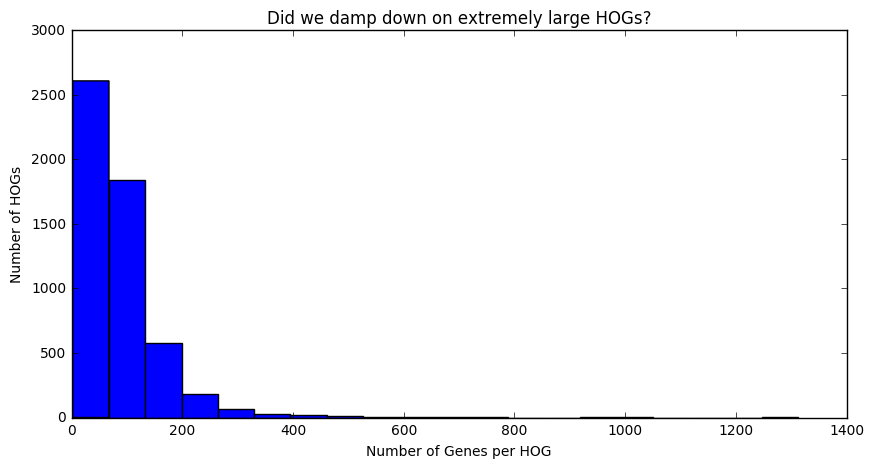

In [14]:
%matplotlib inline
import pandas
lengths = [sum(len(HOGs[label]) for label in group) for group in smart_modified_HOGs]
df = pandas.Series(lengths)#, columns=['Family ID', 'Copies'])
bins = 20
f = df.hist(bins=bins, figsize=(10,5), )#dpi=300)
f.grid(False)
f.set_title("Did we damp down on extremely large HOGs?")
f.set_xlabel("Number of Genes per HOG")
f.set_ylabel("Number of HOGs")

** Conclusion: Just filter out HOGs with > 500 genes**

In [15]:
filtered_smart_modified_HOGs = [group for group in smart_modified_HOGs if sum(len(HOGs[label]) for label in group) < 500]
pp(len(filtered_smart_modified_HOGs) - len(smart_modified_HOGs))

'-15'

In [ ]:
%matplotlib inline
import pandas
lengths = [sum(len(HOGs[label]) for label in group) for group in modified_HOGs_only]
df = pandas.Series(lengths)#, columns=['Family ID', 'Copies'])
f = df.hist(bins=100, figsize=(10,5), )#dpi=300)
f.grid(False)
f.set_title("Did we damp down on extremely large HOGs?")
f.set_xlabel("Number of Genes per HOG")
f.set_ylabel("Number of HOGs")

## Concat Super HOG fasta into new directory

In [ ]:
from os.path import join, basename, splitext
import os
family_out_dir = r"D:\Genomes\Ash_Gene_Families\capped"
HOGfasta = r"D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\Ash_Proteome\Results_Jun25\Orthologues_Jul06\Sequences"
os.makedirs(family_out_dir, exist_ok=True)
for family in filtered_smart_modified_HOGs:
    family_name = ('-'.join(family))[:200] + '.fa'
    with open(join(family_out_dir, family_name), 'wb') as concat:  # output file concatenation
        for hog in family:
            with open(join(HOGfasta, hog + '.fa'), 'rb') as hog_file:  # smaller input file
                concat.write(hog_file.read())  # dump the whole file

In [16]:
pp(len(filtered_smart_modified_HOGs))

'5,316'